In [1]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning) # Ignore User Warning regarding Shapely

import matplotlib.pyplot as plt
import contextily
import pandas as pd
import geopandas as gpd
import pymssql
from shapely import wkb
from tobler.area_weighted import area_interpolate
import os

# Rasterio Installation bug where the Environment variable 'PROJ_LIB' isn't looking in the right file for 'Proj.db' SQLlite Database
# After installation, you need to find the folder where rasterio is storing the 'Proj.db' file and set the environment variable 'PROJ_LIB' to use the right file path
os.environ['PROJ_LIB'] = '/Users/ahadhussain/opt/anaconda3/lib/python3.9/site-packages/rasterio/proj_data/'

In [2]:
database = 'Pushing-P-DB'
table1 = 'dbo.NJ_Cities'
table2 = 'dbo.NJ_Census_Tracts'
user = 'pushing_p'
password  = 't3stP@ssword'
server = 'gen10-data-fundamentals-22-02-sql-server.database.windows.net'


# Retrieve Training Data for Geographically Weighted Regression Model
conn = pymssql.connect(server, user, password, database)

# Query select all rows from SQL tables to insert into their respective DataFrames
query1 = f'SELECT * FROM {table1}'
query2 = f'SELECT * FROM {table2}'
df = pd.read_sql(query1, conn)
tract_info = pd.read_sql(query2, conn)

# Use a function to convert wkb_hex string in SQL database to polygonal geometries (WKB stands for Well-Known Binary, which is commonly used for encoding geographic polygons)
# WKT, well-known text, markup can also be used

def convert_to_polygon(line):
    return wkb.loads(line, hex=True)
df['geometry'] = df['geometry'].apply(convert_to_polygon)
tract_info['geometry'] = tract_info['geometry'].apply(convert_to_polygon)

# Convert from pandas to geopandas dataframes
df = gpd.GeoDataFrame(df, geometry=df['geometry'], crs = 'epsg:4269')
tract_info = gpd.GeoDataFrame(tract_info, geometry=tract_info['geometry'], crs = 'epsg:4269')

# Add % Uninsured Column
df['% Uninsured'] = df['Uninsured Population']/df['City Population']*100
tract_info['% Uninsured'] = tract_info['Uninsured Population']/tract_info['City Population']*100


In [3]:
df.head()

,State,County,City,Unemployment Rate (16 & Over),Median Household Income,City Population,Uninsured Population,"NUI, Under 6 years","NUI, 6-18 years","NUI, 19 to 25 years",...,"NUI, Men","NUI, Women","NUI, White","NUI, African American","NUI, American Indian & Alaska Native Population","NUI, Asians","NUI, Native Hawaiians & Pacific Islanders Population","NUI, Other Races",geometry,% Uninsured
0,New Jersey,Passaic County,Totowa Borough,3.8,96750,10658,482,47,5,40,...,179,303,260,70,0,91,0,14,"POLYGON ((-74.55755 40.57252, -74.55502 40.574...",4.522424
1,New Jersey,Morris County,Chatham Borough,5.9,201923,8704,63,0,11,0,...,9,54,35,2,0,26,0,0,"POLYGON ((-74.04473 40.13486, -74.04219 40.139...",0.723805
2,New Jersey,Morris County,Chatham Township,1.9,202000,10126,89,20,26,0,...,62,27,83,0,0,0,0,6,"POLYGON ((-74.53641 40.89071, -74.52470 40.901...",0.878926
3,New Jersey,Ocean County,Tuckerton Borough,5.5,65918,3352,201,21,0,14,...,104,97,174,1,0,0,0,0,"POLYGON ((-74.79582 40.51527, -74.78903 40.512...",5.996420
4,New Jersey,Monmouth County,Union Beach Borough,4.9,109512,5362,161,47,0,0,...,79,82,161,0,0,0,0,0,"POLYGON ((-73.98849 40.35209, -73.98293 40.353...",3.002611


In [4]:
df.shape

(565, 25)

In [5]:
tract_info.head()

,Census Tract,City Population,Uninsured Population,"NUI, Under 6 years","NUI, 6-18 years","NUI, 19 to 25 years","NUI, 26 to 34 years","NUI, 35 to 44 years","NUI, 45 to 54 years","NUI, 55 to 64 years","NUI, 65 years and older","NUI, Men","NUI, Women","NUI, White","NUI, African American","NUI, American Indian & Alaska Native Population","NUI, Asians","NUI, Native Hawaiians & Pacific Islanders Population",geometry,% Uninsured
0,"Census Tract 30.09, Mercer County, New Jersey",5990.0,444.0,0.0,12.0,45.0,9.0,168.0,187.0,23.0,0.0,398.0,46.0,403.0,18.0,0.0,23.0,0.0,"POLYGON ((-74.69241 40.21257, -74.68845 40.218...",7.412354
1,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-74.06749 40.71857, -74.06673 40.720...",NaN
2,"Census Tract 120.02, Bergen County, New Jersey",3728.0,246.0,5.0,0.0,35.0,20.0,70.0,83.0,33.0,0.0,113.0,133.0,144.0,0.0,54.0,38.0,0.0,"POLYGON ((-74.11939 40.85102, -74.11934 40.853...",6.598712
3,"Census Tract 393, Bergen County, New Jersey",2675.0,106.0,0.0,6.0,6.0,7.0,46.0,21.0,20.0,0.0,55.0,51.0,72.0,0.0,0.0,0.0,0.0,"POLYGON ((-74.26398 41.01427, -74.25753 41.016...",3.962617
4,"Census Tract 82.05, Middlesex County, New Jersey",3431.0,43.0,0.0,0.0,0.0,0.0,0.0,29.0,14.0,0.0,7.0,36.0,14.0,29.0,0.0,0.0,0.0,"POLYGON ((-74.45673 40.31241, -74.45642 40.313...",1.253279


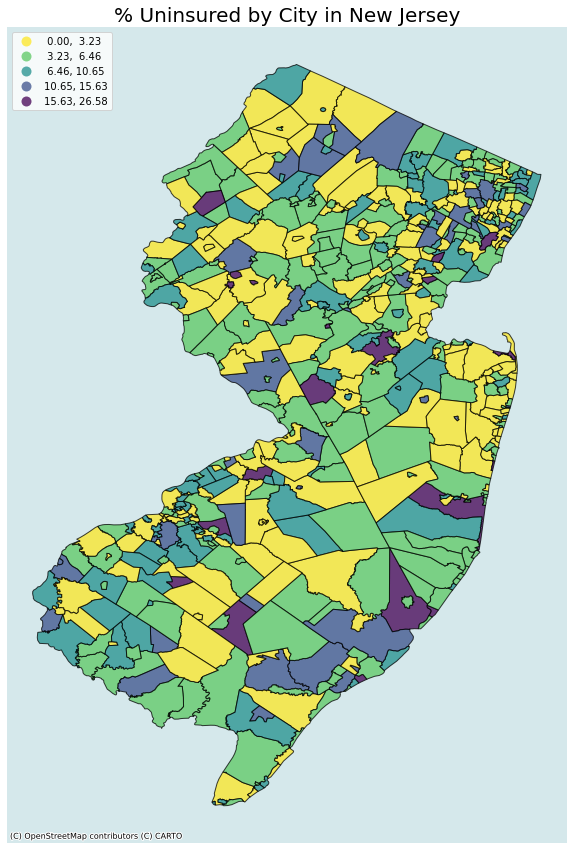

In [6]:
# Set up figure and a single axis
f, ax = plt.subplots(1, figsize=(15, 15))

# Build choropleth
df.plot(
    column='% Uninsured', 
    cmap='viridis_r', 
    scheme='natural_breaks',
    k=5, 
    edgecolor='black', 
    linewidth=1, 
    alpha=0.75, 
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax
)
# Add basemap
contextily.add_basemap(
    ax, 
    source=contextily.providers.CartoDB.Voyager,
)

plt.title('% Uninsured by City in New Jersey', fontsize=20)
ax.set_axis_off();

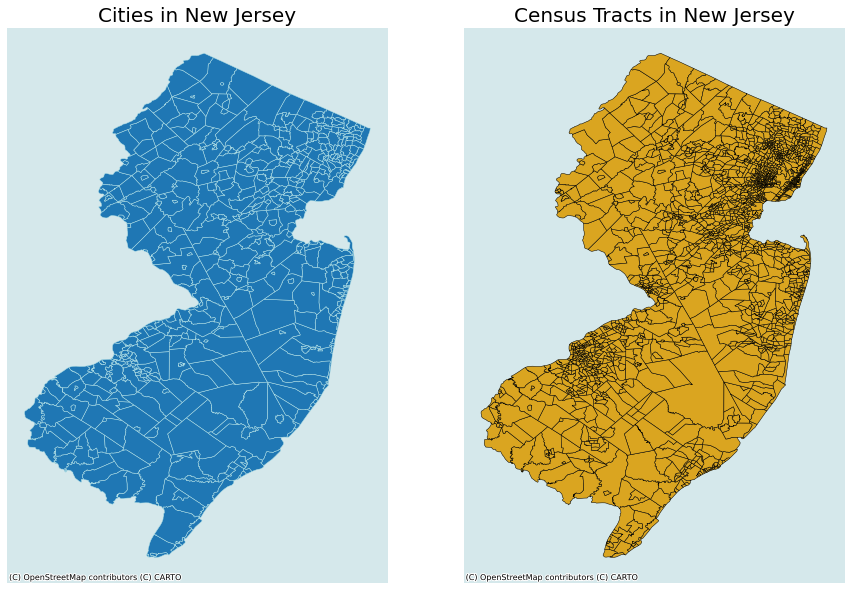

In [7]:
fig, ax = plt.subplots(1,2, figsize=(15,20))

df.plot(ax=ax[0], edgecolor = 'powderblue', linewidth = 0.5)
tract_info.plot(ax=ax[1], color = 'goldenrod',edgecolor = 'black', linewidth = 0.5)


# Add basemap
contextily.add_basemap(
    ax[0], 
    source=contextily.providers.CartoDB.Voyager,
)

contextily.add_basemap(
    ax[1], 
    source=contextily.providers.CartoDB.Voyager
)
ax[0].set_title('Cities in New Jersey', fontsize=20)
ax[1].set_title('Census Tracts in New Jersey', fontsize=20)
ax[0].axis('off')
ax[1].axis('off');


#### Areal Interpolation:
- Areal interpolation is the process making estimates from a source set of polygons to an overlapping but incongruent set of target polygons. 

- The simplest technique available in `tobler` is **simple areal interpolation** in which variables from the source data are weighted according to the overlap between source and target polygons, then reaggregated to fit the target polygon geometries

In [8]:
# Drop rows with null values (about 175 counties are missing healthcare information so we drop those from our analysis)
tract_info.dropna(inplace=True)
tract_info.shape

(1821, 20)

In [9]:
extensive_variables = list(df.drop(['State','County','City','geometry','Unemployment Rate (16 & Over)', '% Uninsured'], axis=1).columns)
results = area_interpolate(source_df=df, target_df=tract_info, intensive_variables = ['Unemployment Rate (16 & Over)'], extensive_variables=extensive_variables)

In [10]:
results.head()

,Median Household Income,City Population,Uninsured Population,"NUI, Under 6 years","NUI, 6-18 years","NUI, 19 to 25 years","NUI, 26 to 34 years","NUI, 35 to 44 years","NUI, 45 to 54 years","NUI, 55 to 64 years",...,"NUI, Men","NUI, Women","NUI, White","NUI, African American","NUI, American Indian & Alaska Native Population","NUI, Asians","NUI, Native Hawaiians & Pacific Islanders Population","NUI, Other Races",Unemployment Rate (16 & Over),geometry
0,3365.678101,434.769705,26.169635,0.000000,3.945855,2.403797,6.803198,3.129471,7.483518,2.403797,...,15.964838,10.204797,24.128675,1.179221,0.0,0.861738,0.000000,0.000000,4.900000,"POLYGON ((-74.69241 40.21257, -74.68845 40.218..."
1,6015.304112,2278.922900,216.460694,7.021865,22.189094,24.623340,41.194942,51.212803,31.738830,29.304584,...,110.945468,105.515226,151.859535,25.746839,0.0,11.703108,0.000000,3.838620,5.200000,"POLYGON ((-74.11939 40.85102, -74.11934 40.853..."
2,25507.755395,2492.489706,82.599648,0.000000,6.991193,4.919728,13.723453,14.759185,10.098390,22.786110,...,32.366633,50.233015,50.750881,0.517866,0.0,13.464520,0.000000,16.571716,7.199999,"POLYGON ((-74.26398 41.01427, -74.25753 41.016..."
3,11852.329643,12625.041630,743.283665,5.536021,48.367342,102.707758,231.056035,175.258771,111.303160,64.829720,...,412.287882,330.995783,457.013104,166.372000,0.0,27.680105,1.456848,65.849513,5.600000,"POLYGON ((-74.45673 40.31241, -74.45642 40.313..."
4,38274.067696,1056.488737,15.434096,0.000000,0.000000,0.000000,1.991496,4.480866,0.000000,8.961733,...,1.493622,13.940473,15.434096,0.000000,0.0,0.000000,0.000000,0.000000,6.600000,"POLYGON ((-74.88215 39.30838, -74.87593 39.311..."


In [11]:
# Create Uninsurance rate columns

results['% Uninsured'] = results['Uninsured Population']/results['City Population']*100
results['% African'] = results['NUI, African American']/results['Uninsured Population']*100
tract_info['% African'] = tract_info['NUI, African American']/tract_info['Uninsured Population']*100
results['% White'] = results['NUI, White']/results['Uninsured Population']*100
tract_info['% White'] = tract_info['NUI, White']/tract_info['Uninsured Population']*100

results.shape

(1821, 24)

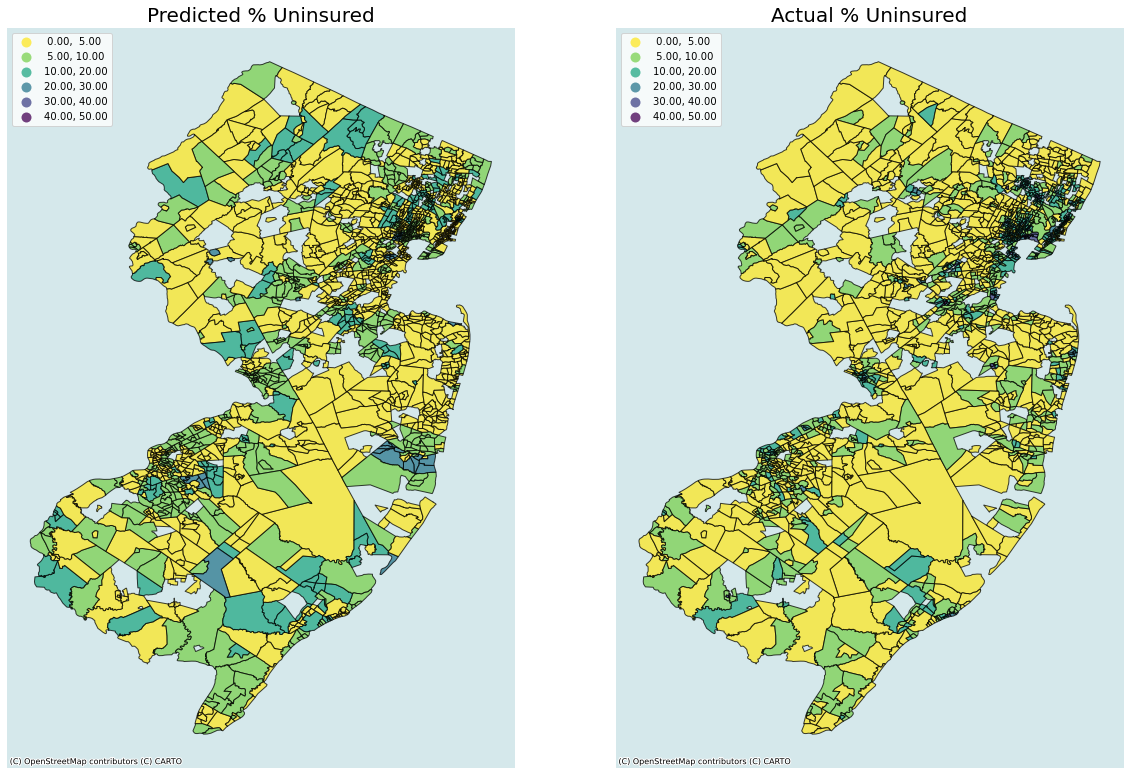

In [12]:
# Set up figure and a single axis
f, ax = plt.subplots(1,2, figsize=(20, 20))

# Build Predicted choropleth
results.plot(
    column='% Uninsured', 
    cmap='viridis_r', 
    scheme="User_Defined",
    classification_kwds=dict(bins=[5,10,20,30,40,50]),
    edgecolor='black', 
    linewidth=1, 
    alpha=0.75, 
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax[0]
)

# Build choropleth
tract_info.plot(
    column='% Uninsured', 
    cmap='viridis_r', 
    scheme="User_Defined",
    classification_kwds=dict(bins=[5,10,20,30,40,50]),
    edgecolor='black', 
    linewidth=1, 
    alpha=0.75, 
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax[1]
)


# Add basemap
contextily.add_basemap(
    ax[0], 
    source=contextily.providers.CartoDB.Voyager,
)

contextily.add_basemap(
    ax[1], 
    source=contextily.providers.CartoDB.Voyager
)

ax[0].set_title('Predicted % Uninsured',fontsize=20)
ax[1].set_title('Actual % Uninsured',fontsize=20)
ax[0].axis('off')
ax[1].axis('off');

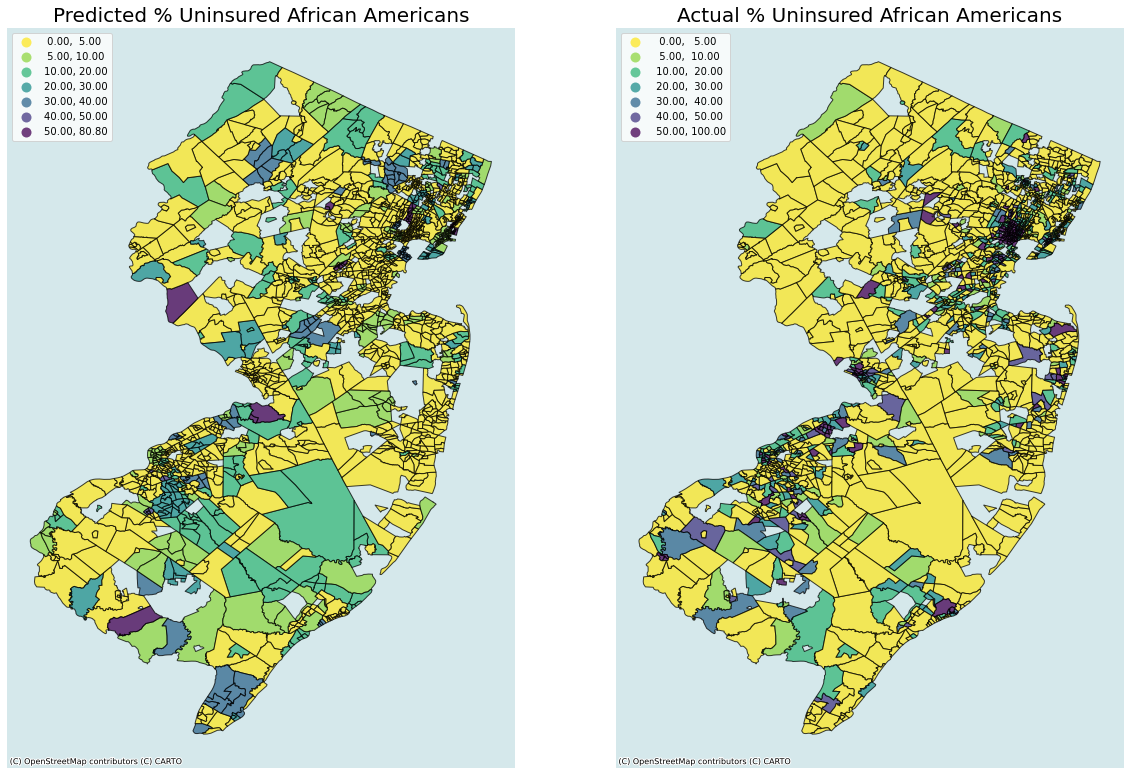

In [13]:
# Set up figure and a single axis
f, ax = plt.subplots(1,2, figsize=(20, 20))

# Build Predicted choropleth
results.plot(
    column='% African', 
    cmap='viridis_r', 
    scheme="User_Defined",
    classification_kwds=dict(bins=[5,10,20,30,40,50]),
    edgecolor='black', 
    linewidth=1, 
    alpha=0.75, 
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax[0]
)

# Build choropleth
tract_info.plot(
    column='% African', 
    cmap='viridis_r', 
    scheme="User_Defined",
    classification_kwds=dict(bins=[5,10,20,30,40,50]),
    edgecolor='black', 
    linewidth=1, 
    alpha=0.75, 
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax[1]
)


# Add basemap
contextily.add_basemap(
    ax[0], 
    source=contextily.providers.CartoDB.Voyager,
)

contextily.add_basemap(
    ax[1], 
    source=contextily.providers.CartoDB.Voyager
)

ax[0].set_title('Predicted % Uninsured African Americans',fontsize=20)
ax[1].set_title('Actual % Uninsured African Americans',fontsize=20)
ax[0].axis('off')
ax[1].axis('off');

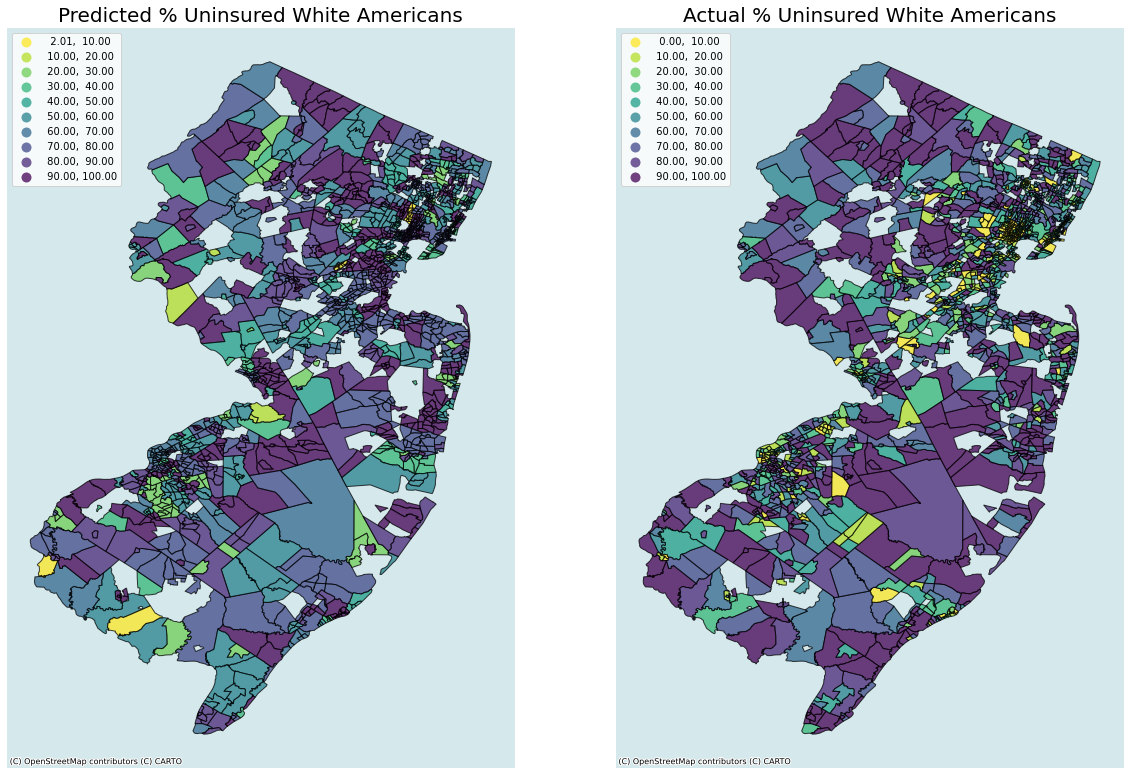

In [14]:
# Set up figure and a single axis
f, ax = plt.subplots(1,2, figsize=(20, 20))

# Build Predicted choropleth
results.plot(
    column='% White', 
    cmap='viridis_r', 
    scheme="User_Defined",
    classification_kwds=dict(bins=[10,20,30,40,50,60,70,80,90,100]),
    edgecolor='black', 
    linewidth=1, 
    alpha=0.75, 
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax[0]
)

# Build choropleth
tract_info.plot(
    column='% White', 
    cmap='viridis_r', 
    scheme="User_Defined",
    classification_kwds=dict(bins=[10,20,30,40,50,60,70,80,90,100]),
    edgecolor='black', 
    linewidth=1, 
    alpha=0.75, 
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax[1]
)


# Add basemap
contextily.add_basemap(
    ax[0], 
    source=contextily.providers.CartoDB.Voyager,
)

contextily.add_basemap(
    ax[1], 
    source=contextily.providers.CartoDB.Voyager
)

ax[0].set_title('Predicted % Uninsured White Americans',fontsize=20)
ax[1].set_title('Actual % Uninsured White Americans',fontsize=20)
ax[0].axis('off')
ax[1].axis('off');

In [15]:
# Export Model using joblib

from joblib import dump
dump(results, 'areal interpolation joblib.model')

['areal interpolation joblib.model']